In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from scipy.spatial.distance import pdist, squareform
import requests
import zipfile
import io
import plotly.express as px
import plotly.graph_objects as go


In [3]:
# Download dos Dados

# url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
# response = requests.get(url)
# z = zipfile.ZipFile(io.BytesIO(response.content))
# z.extractall()


In [4]:
df_ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin1')

df_movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['movie_id', 'title', 'genres'], encoding='latin1')

In [5]:
print(f"Total de usuários: {df_ratings['user_id'].nunique()}")
print(f"Total de filmes: {df_ratings['movie_id'].nunique()}")
print(f"Total de avaliações: {df_ratings.shape[0]}")

Total de usuários: 6040
Total de filmes: 3706
Total de avaliações: 1000209


In [6]:
df_ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [8]:
df_movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


## EDA

In [9]:
fig = px.histogram(df_ratings,
                   x='rating',
                   color='rating',
                   color_discrete_sequence=px.colors.sequential.Viridis,
                   title='Distribuição das Avaliações'
                   )

fig.update_layout(
    xaxis_title='Avaliação (1-5 Estrelas)',
    yaxis_title='Número de Avaliações',
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    font=dict(size=10),
    title_font_size=14,
    showlegend=False,
    bargap=0.2,
    template='plotly_white',
)
fig.show()

In [10]:
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)').astype(float)
movies_per_year = df_movies['year'].dropna().astype(int).value_counts().sort_index()

fig = px.bar(movies_per_year,
             x=movies_per_year.index,
             y=movies_per_year.values,
             labels={'x': 'Ano', 'y': 'Número de Filmes'},
             title='Número de Filmes por Ano',
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Número de Filmes',
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    font=dict(size=10),
    title_font_size=14,
    showlegend=False,
    bargap=0.2,
    template='plotly_white',
)
fig.show()

In [11]:
df_movies.genres.value_counts()

genres
Drama                              843
Comedy                             521
Horror                             178
Comedy|Drama                       162
Comedy|Romance                     142
                                  ... 
Drama|Film-Noir                      1
Comedy|Horror|Sci-Fi                 1
Adventure|Drama|Romance|Sci-Fi       1
Adventure|Animation|Sci-Fi           1
Adventure|Crime|Sci-Fi|Thriller      1
Name: count, Length: 301, dtype: int64

In [12]:
top_genres = df_movies['genres'].value_counts().nlargest(10).reset_index()
top_genres.columns = ['genres', 'count']

fig = px.bar(top_genres,
             x='genres',
             y='count',
             title='Top 10 Gêneros de Filmes',
             color='genres',
             color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(
    xaxis_title='Gêneros',
    yaxis_title='Número de Filmes',
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    font=dict(size=10),
    title_font_size=14,
    showlegend=False,
    bargap=0.2,
    template='plotly_white',
)

fig.show()

In [13]:
genres_expanded = df_movies['genres'].str.split('|', expand=True).stack()
genres_count = genres_expanded.value_counts()

fig = px.bar(genres_count,
             x=genres_count.index,
             y=genres_count.values,
             labels={'x': 'Gênero', 'y': 'Número de Filmes'},
             title='Número de Filmes por Gênero',
             color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(
    xaxis_title='Gênero',
    yaxis_title='Número de Filmes',
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    font=dict(size=10),
    title_font_size=14,
    showlegend=False,
    bargap=0.2,
    template='plotly_white',
)
fig.show()


## Preprocessing

In [14]:
duplicated_entries = df_ratings.groupby(['user_id', 'movie_id']).size().reset_index(name='counts')
duplicated_entries = duplicated_entries[duplicated_entries['counts'] > 1]

print(f"Total de registros com múltiplas avaliações para o mesmo filme pelo mesmo usuário: {duplicated_entries.shape[0]}")


Total de registros com múltiplas avaliações para o mesmo filme pelo mesmo usuário: 0


In [15]:
# Criando a matriz de usuário-filme
# Cada linha representa um usuário e cada coluna um filme, com os valores sendo as avaliações.
rating_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating')

print("Shape da matriz de avaliações:", rating_matrix.shape)
print(rating_matrix.head())

Shape da matriz de avaliações: (6040, 3706)
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5          NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   

movie_id  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
user_id                                                               
1          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   Na

In [16]:
rating_matrix_filled = rating_matrix.fillna(0)

# Normalizando os dados usando MinMaxScaler - transforma os dados para o intervalo [0, 1]
scaler = MinMaxScaler()
rating_matrix_scaled = scaler.fit_transform(rating_matrix_filled)

rating_matrix_scaled = pd.DataFrame(rating_matrix_scaled,
                                           index=rating_matrix_filled.index,
                                           columns=rating_matrix_filled.columns)

print("\nShape da matriz de avaliações:",rating_matrix_scaled.shape)
print(rating_matrix_scaled.head())


Shape da matriz de avaliações: (6040, 3706)
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5          0.0   0.0   0.0   0.0   0.0   0.4   0.0   0.0   0.0   0.0  ...   

movie_id  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
user_id                                                               
1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0

In [17]:
# Calculando a matriz de distância usando a métrica cosseno
matriz_distancia_cos = pairwise_distances(rating_matrix_scaled.values, metric='cosine', n_jobs=-1)
matriz_distancia_euclidiana = pairwise_distances(rating_matrix_scaled.values, metric='euclidean', n_jobs=-1)

df_distancia_cos = pd.DataFrame(matriz_distancia_cos, index=rating_matrix_scaled.index, columns=rating_matrix_scaled.index)
df_distancia_euclidiana = pd.DataFrame(matriz_distancia_euclidiana, index=rating_matrix_scaled.index, columns=rating_matrix_scaled.index)

### Silhuetas negativas para cos eram inesperadas mas de toda forma vemos que k=2 apresenta silhueta consideravelmente maior

In [31]:
silhouette_scores = []
inertias = []
k_values = list(range(2, 15))

# Testar valores de K de 2 até 15
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rating_matrix_scaled)
    
    silhouette_avg = silhouette_score(df_distancia_cos, cluster_labels, metric="precomputed")
    silhouette_scores.append(silhouette_avg)

    inertias.append(kmeans.inertia_)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(2, 15)),  
    y=silhouette_scores,
    mode='lines+markers',
    marker=dict(size=8, symbol='circle'),
    name='Coeficiente de Silhueta'
))

fig.add_trace(go.Scatter(
    x=k_values,
    y=inertias,
    mode='lines+markers',
    name='Inertia',
    yaxis='y2'
))

fig.update_layout(
    title_text='<b>Silhouette Score e Inertia - KMeans Clustering(cos)</b>',
    xaxis=dict(
        title='Número de Clusters (K)',
        tickmode='array',
        tickvals=k_values
    ),
    yaxis=dict(
        title='Silhouette Score',
        side='left'
    ),
    yaxis2=dict(
        title='Inertia',
        side='right',
        overlaying='y'
    ),
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

In [32]:
silhouette_scores = []
inertias = []
k_values = list(range(2, 15))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rating_matrix_scaled)
    
    silhouette_avg = silhouette_score(rating_matrix_scaled, cluster_labels, metric="euclidean")
    silhouette_scores.append(silhouette_avg)
    
    # Inertia (soma das distâncias quadradas ao centroide)
    inertias.append(kmeans.inertia_)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=k_values,
    y=silhouette_scores,
    mode='lines+markers',
    name='Silhouette Score',
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=k_values,
    y=inertias,
    mode='lines+markers',
    name='Inertia',
    yaxis='y2'
))

fig.update_layout(
    title_text='<b>Silhouette Score e Inertia - KMeans Clustering(euclidian)</b>',
    xaxis=dict(
        title='Número de Clusters (K)',
        tickmode='array',
        tickvals=k_values
    ),
    yaxis=dict(
        title='Silhouette Score',
        side='left'
    ),
    yaxis2=dict(
        title='Inertia',
        side='right',
        overlaying='y'
    ),
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

### K=2 parece um numero baixo para a aplicação, o que pode indicar alguma forma de hierarquia de clusters 

In [20]:
kmeans = KMeans(n_clusters=2, random_state=42) 
cluster_labels = kmeans.fit_predict(rating_matrix_scaled)
print(pd.Series(cluster_labels).value_counts())


1    4883
0    1157
Name: count, dtype: int64


## DBSCAN

In [21]:
def calculate_knn_distances(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    return distances[:, -1]

def get_eps(distances):
    sorted_distances = np.sort(distances)
    x = np.arange(len(sorted_distances))

    fig = px.line(x=x, y=sorted_distances,
                  labels={'x': 'Pontos ordenados pela distância',
                          'y': f'Distância {k}-NN'},
                  title=f'Método do Cotovelo para eps Ótimo: Distâncias {k}-NN')

    knee_idx = np.argmax(np.diff(sorted_distances, 2)) + 2
    knee_eps = sorted_distances[knee_idx]

    fig.add_vline(x=knee_idx,
                  line_dash="dash",
                  line_color="red",
                  annotation_text=f'(eps) = {knee_eps:.2f}',
                  annotation_position="top right")
    
    fig.update_layout(
        xaxis_title_font_size=12,
        yaxis_title_font_size=12,
        title_font_size=14,
        hovermode="x unified",
        template="plotly_white", 
        height=500,
        width=900 
    )

    fig.show()

    return knee_eps


k = 10 
distances = calculate_knn_distances(rating_matrix_scaled, k)
optimal_eps = get_eps(distances)

In [22]:
for i in [0.25, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]:
    print('Clusters com eps:', i)
    dbscan = DBSCAN(eps=i, min_samples=10, metric='precomputed')
    clusters = dbscan.fit_predict(df_distancia_cos)
    dist = pd.Series(clusters)
    dist.name = 'Clusters'
    print(dist.value_counts())

Clusters com eps: 0.25
Clusters
-1    6040
Name: count, dtype: int64
Clusters com eps: 0.4
Clusters
-1    5881
 0     130
 1      23
 2       6
Name: count, dtype: int64
Clusters com eps: 0.5
Clusters
-1    4789
 0    1112
 1      99
 2      20
 3      10
 4      10
Name: count, dtype: int64
Clusters com eps: 0.55
Clusters
-1    3755
 0    2253
 2      18
 1      14
Name: count, dtype: int64
Clusters com eps: 0.6
Clusters
 0    3599
-1    2414
 2      16
 1      11
Name: count, dtype: int64
Clusters com eps: 0.65
Clusters
 0    5028
-1    1012
Name: count, dtype: int64
Clusters com eps: 0.7
Clusters
 0    5718
-1     322
Name: count, dtype: int64


### eps = 0.5 parece melhor, apesar de todos apresentarem muitos outliers

## Clustering Hierarquico

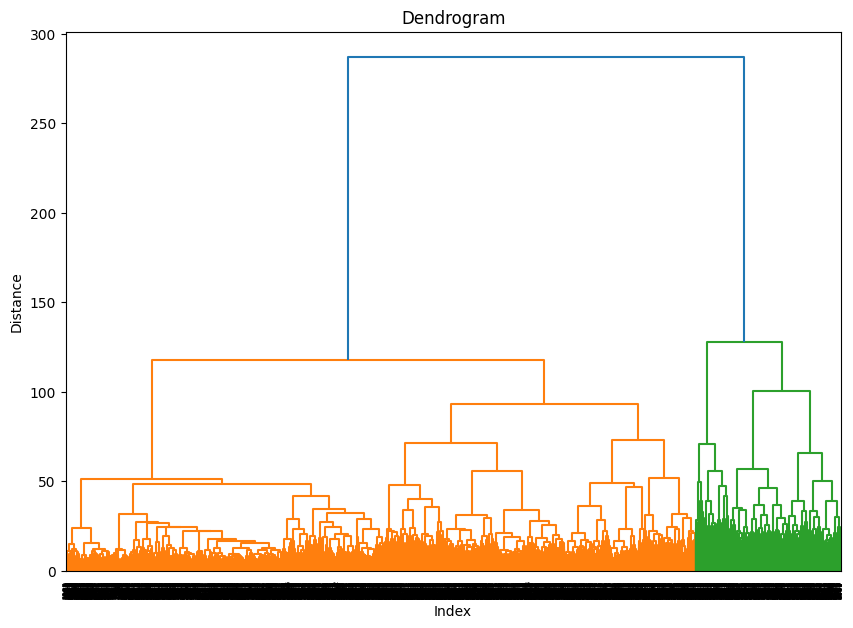

In [23]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

link_matrix = linkage(rating_matrix_scaled, method='ward')
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(link_matrix)
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

In [24]:
n_clusters_agg_initial = 2 

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_agg_initial, linkage='ward')
user_clusters_agg = agg_clustering.fit_predict(rating_matrix_scaled)

print(f"Primeiros 10 rótulos de cluster para Agglomerative Clustering (n_clusters={n_clusters_agg_initial}):")
print(user_clusters_agg[:10])
print(f"Distribuição dos clusters para Agglomerative Clustering (n_clusters={n_clusters_agg_initial}):")
print(pd.Series(user_clusters_agg).value_counts().sort_index())

Primeiros 10 rótulos de cluster para Agglomerative Clustering (n_clusters=2):
[1 1 1 1 1 1 1 1 1 0]
Distribuição dos clusters para Agglomerative Clustering (n_clusters=2):
0    1128
1    4912
Name: count, dtype: int64


Desvio Padrão das Avaliações por Usuário (amostra):
    user_id  std_rating
0        1    0.680967
1        2    1.001513
2        3    0.984985
3        4    1.077917
4        5    1.132699

Total de usuários com desvio padrão calculado: 6040


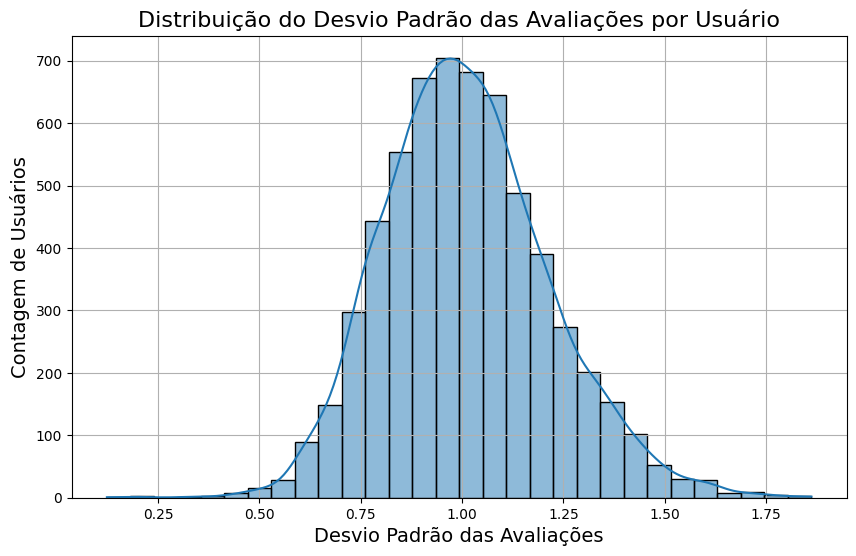


Estatísticas IQR para Desvio Padrão das Avaliações:
  Q1 (25º percentil): 0.869
  Q3 (75º percentil): 1.135
  IQR (Q3 - Q1): 0.266
  Limite Inferior (Q1 - 1.5*IQR): 0.471
  Limite Superior (Q3 + 1.5*IQR): 1.533

Número de usuários identificados como outliers pelo IQR do Desvio Padrão: 82
Exemplo de IDs de usuários outliers: [41, 46, 87, 89, 206, 283, 296, 357, 446, 447]


In [25]:
user_rating_std = df_ratings.groupby('user_id')['rating'].std()

user_std_df = pd.DataFrame(user_rating_std).rename(columns={'rating': 'std_rating'})
user_std_df = user_std_df.reset_index()

print("Desvio Padrão das Avaliações por Usuário (amostra):\n", user_std_df.head())
print(f"\nTotal de usuários com desvio padrão calculado: {len(user_std_df)}")


plt.figure(figsize=(10, 6))
sns.histplot(user_std_df['std_rating'], bins=30, kde=True)
plt.title('Distribuição do Desvio Padrão das Avaliações por Usuário', fontsize=16)
plt.xlabel('Desvio Padrão das Avaliações', fontsize=14)
plt.ylabel('Contagem de Usuários', fontsize=14)
plt.grid(True)
plt.show()


Q1 = user_std_df['std_rating'].quantile(0.25)
Q3 = user_std_df['std_rating'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_std = Q1 - 1.5 * IQR
upper_bound_std = Q3 + 1.5 * IQR

print(f"\nEstatísticas IQR para Desvio Padrão das Avaliações:")
print(f"  Q1 (25º percentil): {Q1:.3f}")
print(f"  Q3 (75º percentil): {Q3:.3f}")
print(f"  IQR (Q3 - Q1): {IQR:.3f}")
print(f"  Limite Inferior (Q1 - 1.5*IQR): {lower_bound_std:.3f}")
print(f"  Limite Superior (Q3 + 1.5*IQR): {upper_bound_std:.3f}")

outlier_user_ids = user_std_df[
    (user_std_df['std_rating'] < lower_bound_std) | 
    (user_std_df['std_rating'] > upper_bound_std)
]['user_id']

print(f"\nNúmero de usuários identificados como outliers pelo IQR do Desvio Padrão: {len(outlier_user_ids)}")

if len(outlier_user_ids) > 0:
    print("Exemplo de IDs de usuários outliers:", outlier_user_ids.tolist()[:10])
else:
    print("Nenhum usuário identificado como outlier pelo critério IQR do Desvio Padrão.")


### Remoção de usuários com desvio padrao de ratings muito anormal

In [26]:
users_to_keep = rating_matrix_scaled.index.difference(outlier_user_ids)
rating_matrix_cleaned = rating_matrix_scaled.loc[users_to_keep]

print(f"Shape da matriz original: {rating_matrix_scaled.shape}")
print(f"Shape da matriz após remoção de outliers: {rating_matrix_cleaned.shape}")

Shape da matriz original: (6040, 3706)
Shape da matriz após remoção de outliers: (5958, 3706)


## Redução da Dimensionalidade

Shape dos dados após PCA (600 componentes): (5958, 600)
Variância explicada pelos 600 primeiros componentes principais: 0.80


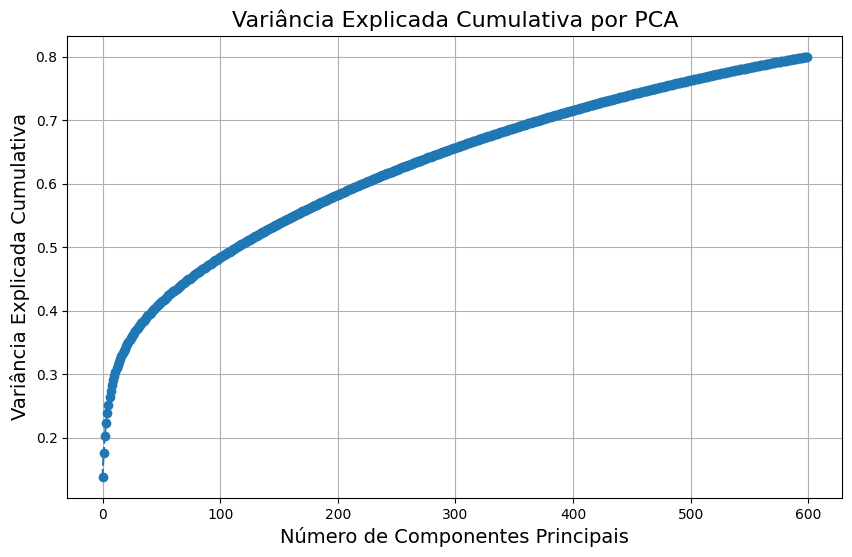

In [ ]:
# Redução de cerca de 10x a dimensionalidade
n_components_pca = 600 

pca = PCA(n_components=n_components_pca, random_state=42)
rating_pca = pca.fit_transform(rating_matrix_cleaned)

print(f"Shape dos dados após PCA ({n_components_pca} componentes): {rating_pca.shape}")
print(f"Variância explicada pelos {n_components_pca} primeiros componentes principais: {np.sum(pca.explained_variance_ratio_):.2f}")

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Variância Explicada Cumulativa por PCA', fontsize=16)
plt.xlabel('Número de Componentes Principais', fontsize=14)
plt.ylabel('Variância Explicada Cumulativa', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

### Diminuição significativa (cerca de 10x) do numero de componentes mantendo cerca de 80% da informação

Shape dos dados após SVD (600 componentes): (5958, 600)


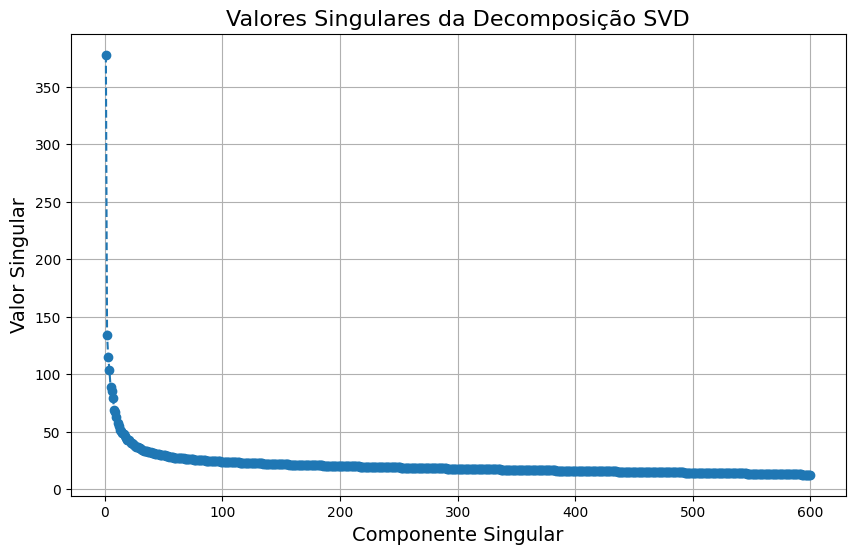

In [28]:
n_components_svd = 600 

svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
rating_svd = svd.fit_transform(rating_matrix_cleaned)

print(f"Shape dos dados após SVD ({n_components_svd} componentes): {rating_svd.shape}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(svd.singular_values_) + 1), svd.singular_values_, marker='o', linestyle='--')
plt.title('Valores Singulares da Decomposição SVD', fontsize=16)
plt.xlabel('Componente Singular', fontsize=14)
plt.ylabel('Valor Singular', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

## Análise com Redução de Dimensionalidade

### K-means

In [43]:
silhouette_scores = []
inertias = []
k_values = list(range(2, 21))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rating_pca)
    
    silhouette_avg = silhouette_score(rating_pca, cluster_labels, metric="euclidean")
    silhouette_scores.append(silhouette_avg)
    
    # Inertia (soma das distâncias quadradas ao centroide)
    inertias.append(kmeans.inertia_)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=k_values,
    y=silhouette_scores,
    mode='lines+markers',
    name='Silhouette Score',
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=k_values,
    y=inertias,
    mode='lines+markers',
    name='Inertia',
    yaxis='y2'
))

fig.update_layout(
    title_text='<b>Silhouette Score e Inertia PCA </b>',
    xaxis=dict(
        title='Número de Clusters (K)',
        tickmode='array',
        tickvals=k_values
    ),
    yaxis=dict(
        title='Silhouette Score',
        side='left'
    ),
    yaxis2=dict(
        title='Inertia',
        side='right',
        overlaying='y'
    ),
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

In [44]:
silhouette_scores = []
inertias = []
k_values = list(range(2, 21))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rating_svd)
    
    silhouette_avg = silhouette_score(rating_pca, cluster_labels, metric="euclidean")
    silhouette_scores.append(silhouette_avg)
    
    # Inertia (soma das distâncias quadradas ao centroide)
    inertias.append(kmeans.inertia_)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=k_values,
    y=silhouette_scores,
    mode='lines+markers',
    name='Silhouette Score',
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=k_values,
    y=inertias,
    mode='lines+markers',
    name='Inertia',
    yaxis='y2'
))

fig.update_layout(
    title_text='<b>Silhouette Score e Inertia SVD </b>',
    xaxis=dict(
        title='Número de Clusters (K)',
        tickmode='array',
        tickvals=k_values
    ),
    yaxis=dict(
        title='Silhouette Score',
        side='left'
    ),
    yaxis2=dict(
        title='Inertia',
        side='right',
        overlaying='y'
    ),
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

#### Silhueta decai mais rapido com SVD

#### O cotovelo da Inertia aparece aproximadamente em K = 4 ou K = 5 em ambas.

In [47]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(rating_pca)

df_clusters = pd.DataFrame(rating_pca)
df_clusters['cluster'] = labels

In [48]:
print(df_clusters['cluster'].value_counts().sort_index())


cluster
0     788
1    3449
2     882
3     389
4     450
Name: count, dtype: int64


In [ ]:
df_profile = pd.DataFrame(rating_matrix_cleaned)
df_profile['cluster'] = labels

cluster_profiles = df_profile.groupby('cluster').mean()

print(cluster_profiles.head())

movie_id      1         2         3         4         5         6     \
cluster                                                                
0         0.517005  0.108122  0.091624  0.044670  0.069543  0.230964   
1         0.152972  0.021050  0.021861  0.003363  0.008118  0.034619   
2         0.324717  0.115420  0.032880  0.003401  0.013152  0.171655   
3         0.722365  0.376350  0.227763  0.087404  0.178920  0.485347   
4         0.474222  0.094222  0.045778  0.017333  0.028889  0.190222   

movie_id      7         8         9         10    ...      3943      3944  \
cluster                                           ...                       
0         0.123096  0.006091  0.003807  0.172081  ...  0.021066  0.001777   
1         0.017512  0.003247  0.002493  0.020992  ...  0.003943  0.000348   
2         0.015646  0.007256  0.015420  0.203628  ...  0.004082  0.000000   
3         0.275064  0.038046  0.074036  0.482262  ...  0.033933  0.002571   
4         0.074667  0.008000  0.0

In [ ]:
df_users_clusters = pd.DataFrame({'user_id': rating_matrix_cleaned.index, 'cluster': labels})
df_full = df_ratings.merge(df_users_clusters, on='user_id')

df_full = df_full.merge(df_movies[['movie_id', 'title', 'genres']], on='movie_id')

df_full.head()

,user_id,movie_id,rating,timestamp,cluster,title,genres
0,1,1193,5,978300760,1,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,1,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,1,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,1,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,1,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [ ]:
for cluster in sorted(df_full['cluster'].unique()):
    df_cluster = df_full[df_full['cluster'] == cluster]
    
    top_genres = df_cluster['genres'].value_counts().head(10).reset_index()
    top_genres.columns = ['Genre', 'Count']
    
    fig = px.bar(top_genres, x='Genre', y='Count', title=f'Top 10 Gêneros - Cluster {cluster}')
    fig.show()

In [ ]:
genres_expanded = df_movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
genres_expanded.name = 'genre'

df_movies_expanded = df_movies[['movie_id', 'title']].join(genres_expanded)

genres_count = df_movies_expanded['genre'].value_counts()
top_genres = genres_count.head(10).index.tolist()

df_movies_expanded['genre_grouped'] = df_movies_expanded['genre'].apply(lambda x: x if x in top_genres else 'Outros')

df_users_clusters = pd.DataFrame({'user_id': rating_matrix_cleaned.index, 'cluster': labels})

df_full = df_ratings.merge(df_users_clusters, on='user_id')

df_full = df_full.merge(df_movies_expanded[['movie_id', 'genre_grouped']], on='movie_id')

genre_cluster = df_full.groupby(['cluster', 'genre_grouped']).size().unstack(fill_value=0)

genre_cluster_norm = genre_cluster.div(genre_cluster.sum(axis=1), axis=0)

# Plotar heatmap com proporção
fig = px.imshow(genre_cluster_norm,
                labels=dict(x="Gênero", y="Cluster", color="Proporção de Avaliações"),
                title="Heatmap Normalizado de Gêneros por Cluster",
                aspect="auto")

fig.update_xaxes(side="bottom")
fig.show()


In [ ]:
df_users_clusters = pd.DataFrame({'user_id': rating_matrix_cleaned.index, 'cluster': labels})

# Unir ratings com clusters
df_full = df_ratings.merge(df_users_clusters, on='user_id')

df_full = df_full.merge(df_movies[['movie_id', 'title']], on='movie_id')

df_five_stars = df_full[df_full['rating'] == 5]

# Gerar Top 10 filmes com 5 estrelas por cluster
for cluster in sorted(df_five_stars['cluster'].unique()):
    df_cluster = df_five_stars[df_five_stars['cluster'] == cluster]
    
    top_movies = df_cluster['title'].value_counts().head(10).reset_index()
    top_movies.columns = ['Movie', 'Five_Star_Count']
    
    fig = px.bar(top_movies, x='Movie', y='Five_Star_Count',
                 title=f'Top 10 Filmes 5 Estrelas - Cluster {cluster}')
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

### É possível perceber que apesar de muitos gêneros se repetirem, ao analisar os cinco estrelas vemos uma certadiferença entre os grupos

### É interessante ver grupos que tendem mais para Star Wars e sci-fi e outros avaliam melhor filmes mais clássicos como Shawshank Redemption

### Entretanto, ainda é possível notar uma certa sobreposição entre os grupos

### DBSCAN

In [37]:
def calculate_knn_distances(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    return distances[:, -1]

def get_eps(distances):
    sorted_distances = np.sort(distances)
    x = np.arange(len(sorted_distances))

    fig = px.line(x=x, y=sorted_distances,
                  labels={'x': 'Pontos ordenados pela distância',
                          'y': f'Distância {k}-NN'},
                  title=f'Método do Cotovelo para eps Ótimo: Distâncias {k}-NN')

    knee_idx = np.argmax(np.diff(sorted_distances, 2)) + 2
    knee_eps = sorted_distances[knee_idx]

    fig.add_vline(x=knee_idx,
                  line_dash="dash",
                  line_color="red",
                  annotation_text=f'(eps) = {knee_eps:.2f}',
                  annotation_position="top right")
    
    fig.update_layout(
        xaxis_title_font_size=12,
        yaxis_title_font_size=12,
        title_font_size=14,
        hovermode="x unified",
        template="plotly_white", 
        height=500,
        width=900 
    )

    fig.show()

    return knee_eps


k = 10 
distances = calculate_knn_distances(rating_pca, k)
optimal_eps = get_eps(distances)

In [42]:
for i in [0.01, 0.05, 0.3, 0.4, 0.5, 0.6]:
    print('Clusters com eps:', i)
    dbscan = DBSCAN(eps=i, min_samples=5)
    clusters = dbscan.fit_predict(rating_pca)
    dist = pd.Series(clusters)
    dist.name = 'Clusters'
    print(dist.value_counts())

Clusters com eps: 0.01
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.05
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.3
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.4
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.5
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.6
Clusters
-1    5958
Name: count, dtype: int64


In [41]:
for i in [0.01, 0.05, 0.3, 0.4, 0.5, 0.6]:
    print('Clusters com eps:', i)
    dbscan = DBSCAN(eps=i, min_samples=5)
    clusters = dbscan.fit_predict(rating_svd)
    dist = pd.Series(clusters)
    dist.name = 'Clusters'
    print(dist.value_counts())

Clusters com eps: 0.01
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.05
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.3
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.4
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.5
Clusters
-1    5958
Name: count, dtype: int64
Clusters com eps: 0.6
Clusters
-1    5958
Name: count, dtype: int64


### Em geral, resultados pouco explicativos com DBSCAN

### Hierárquico

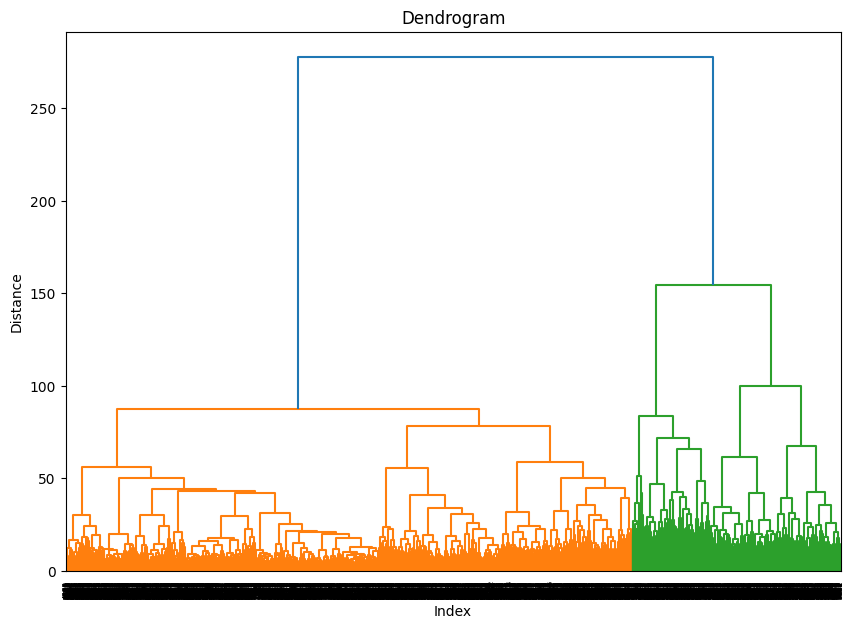

In [ ]:
link_matrix = linkage(rating_pca, method='ward')
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(link_matrix)
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

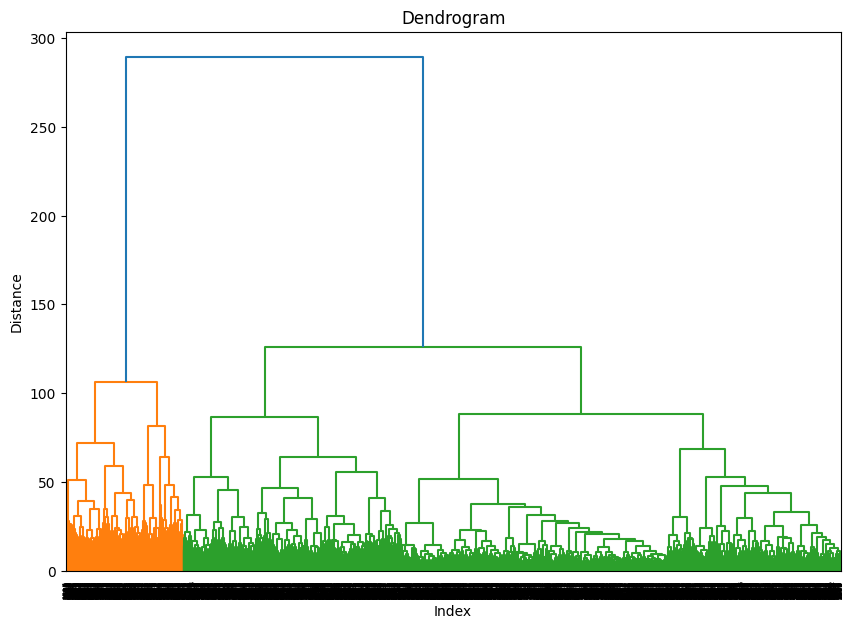

In [46]:
link_matrix = linkage(rating_svd, method='ward')
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(link_matrix)
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

In [89]:
from scipy.cluster.hierarchy import fcluster

user_clusters_agg = fcluster(link_matrix, t=5, criterion='maxclust')

print("Distribuição dos clusters (corte manual no dendrograma):")
print(pd.Series(user_clusters_agg).value_counts().sort_index())

Distribuição dos clusters (corte manual no dendrograma):
1     585
2     322
3    1677
4    2042
5    1332
Name: count, dtype: int64


In [90]:
import pandas as pd
import plotly.express as px

df_users_clusters = pd.DataFrame({'user_id': rating_matrix_cleaned.index, 'cluster': user_clusters_agg})

df_full = df_ratings.merge(df_users_clusters, on='user_id')

# Explodir os gêneros dos filmes
genres_expanded = df_movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
genres_expanded.name = 'genre'
df_movies_expanded = df_movies[['movie_id', 'title']].join(genres_expanded)

genres_count = df_movies_expanded['genre'].value_counts()
top_genres = genres_count.head(10).index.tolist()
df_movies_expanded['genre_grouped'] = df_movies_expanded['genre'].apply(lambda x: x if x in top_genres else 'Outros')

df_full = df_full.merge(df_movies_expanded[['movie_id', 'genre_grouped']], on='movie_id')

df_full = df_full.merge(df_movies[['movie_id', 'title']], on='movie_id', how='left')

genre_cluster = df_full.groupby(['cluster', 'genre_grouped']).size().unstack(fill_value=0)
genre_cluster_norm = genre_cluster.div(genre_cluster.sum(axis=1), axis=0)

fig = px.imshow(genre_cluster_norm,
                labels=dict(x="Gênero", y="Cluster", color="Proporção de Avaliações"),
                title="Heatmap Normalizado de Gêneros por Cluster (Aglomerativo)",
                aspect="auto")

fig.update_xaxes(side="bottom")
fig.show()


### Conseguimos observar certos clusters com maiores avaliações de gêneros diferentes

### Entretanto, drama e comédia sempre tendem a dominar

In [ ]:
# Analisar Top 10 filmes 5 estrelas por cluster
df_five_stars = df_full[df_full['rating'] == 5]

for cluster in sorted(df_five_stars['cluster'].unique()):
    df_cluster = df_five_stars[df_five_stars['cluster'] == cluster]
    
    top_movies = df_cluster['title'].value_counts().head(10).reset_index()
    top_movies.columns = ['Movie', 'Five_Star_Count']
    
    fig = px.bar(top_movies, x='Movie', y='Five_Star_Count',
                 title=f'Top 10 Filmes 5 Estrelas - Cluster {cluster} (Aglomerativo)')
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

### Com k=5 ainda vemos uma certa semelhança entre os clusters, com star wars aparecendo no topo de varios

### Apesar de um resultado interessante, aparentemente o kmeans conseguiu reunir clusters mais diversos.